In [1]:
import utils
import log_parser
import pandas as pd
import random
import re
from numpy import NaN
from numpy import mean


In [2]:
import pandas as pd
df = pd.read_pickle('./data.pickle')

In [3]:
frames = []
for filename in df["file"].unique():
  frames.append(df[df["file"] == filename])
  print(filename)

smallclam_lf_goal33_mult_succ_82_plus_assoc
smallclam_lf_goal7_theorem0_54_plus_comm
smallclam_lf_goal79_theorem0_43_append_assoc
smallclam_lf_goal7_theorem0_58_plus_comm
smallclam_lf_goal33_mult_succ_81_plus_assoc
smallclam_lf_goal17_theorem0_40_lem
smallclam_lf_goal18_theorem0_41_append_assoc
smallclam_lf_goal32_rotate_len_append_51_append_assoc
smallclam_lf_goal83_theorem0_50_append_assoc
smallclam_lf_goal34_plus_qmult_66_plus_commut
smallclam_lf_goal21_theorem0_49_append_assoc


In [4]:
def random_rank(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for iter in range(100):
      for i, _ in frames[index].iterrows():
        frames[index].loc[i, 'alpha'] = random.uniform(0,1)    
      all_equiv = []
      sorted_frame = frames[index].sort_values('alpha', ascending=False, ignore_index=True)
      for i, row in sorted_frame.iterrows():
        if row['is_equiv']:
          all_equiv.append(i)
      if not all_equiv:
        all_equiv.append(NaN)
      first_rank[index].append(all_equiv[0])
      mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [5]:
first_ranks, mean_ranks = random_rank(frames)

/tmp/ipykernel_16747/1759657811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, 'alpha'] = random.uniform(0,1)
/tmp/ipykernel_16747/1759657811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, 'alpha'] = random.uniform(0,1)
/tmp/ipykernel_16747/1759657811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [6]:
random_rank(frames)

([nan, 29.42, 53.85, 26.2, nan, 22.99, 51.57, 5.35, 5.99, 24.11, 6.99],
 [nan,
  93.33166666666666,
  74.91,
  39.11,
  nan,
  57.33,
  76.315,
  22.95166666666666,
  23.196666666666665,
  58.6925,
  24.578333333333333])

In [7]:
def smallest_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values('lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [8]:
first_ranks, avg_ranks = smallest_first(frames)

/tmp/ipykernel_16747/1010753065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
/tmp/ipykernel_16747/1010753065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
/tmp/ipykernel_16747/1010753065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [9]:
import coq_serapy

def use_lemma(lemma_name):
  return f'rewrite {lemma_name} || rewrite <- {lemma_name} || apply {lemma_name}.'

def use_helper_lemma_then_IH(prelude, before_helper_cmds, helper_lemma, stmts=[]):
    if isinstance(prelude, str):
        prelude = [s.strip() + '.' for s in prelude.strip().split(".")[:-1]]
    with coq_serapy.SerapiContext(
            ["sertop", "--implicit"],    
            None,
            "/home/yousef/lemmaranker/benchmark/smallclam") as coq:
        for stmt in prelude:
            coq.run_stmt(stmt.strip('-'))
        for stmt in stmts:
            coq.run_stmt(stmt)
        try:
            cmds_left, cmds_run = coq.run_into_next_proof(
            before_helper_cmds)
            for cmd in cmds_left:
                coq.run_stmt(cmd)
            try:
                coq.run_stmt(use_lemma(helper_lemma))
                ind_hyps = []
                for hyp in coq.proof_context.fg_goals[0].hypotheses:
                    match = re.match('(?P<name>IH\w*)[ ]?:',hyp)
                    if match:
                        ind_hyps.append(match.groups()[0])
                if ind_hyps:
                    use_ind_hyps_cmd = ' || '.join(use_lemma(hyp)[:-1] for hyp in ind_hyps) + '|| fail.'
                    try:
                        coq.run_stmt(use_ind_hyps_cmd)
                        return True, True
                    except:
                        return True, False
            except:
                return False, False
        except coq_serapy.CoqExn:
            return False, False
        except Exception as e:
            return False, False


In [10]:

def lemma_enables_IH(row):
  try:
    prelude = row["prelude"]
    lemma = row["lemma"]
    lemma_name = row["lemma_name"]
    theorem_stmt = row["theorem"]
    theorem_proof = [cmd.strip() + '.' for cmd in row["theorem_proof"].replace('-', ' ').replace('+', ' ').split('.') if cmd]
    lfind_idx = theorem_proof.index('lfind.')
    before_lfind_cmds, after_lfind_cmds = theorem_proof[:lfind_idx], theorem_proof[lfind_idx+1:]
    stmts = [lemma, 'Admitted.']
    used_IH_before = any('IH' in cmd for cmd in before_lfind_cmds)
    proof_cmds = [theorem_stmt] + before_lfind_cmds # + ['rewrite IHx | rewrite IHy | rewrite <- IHx | rewrite <- IHy | apply IHx | apply IHy | fail.', 'Admitted.'] + after_lfind_cmds
    return use_helper_lemma_then_IH(prelude, proof_cmds, lemma_name, stmts)[1]
  except:
    return False

In [ ]:
def enables_IH(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    # for i, row in frames[index].iterrows():
    #   frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
    all_equiv = []
    sorted_frame = frames[index].sort_values(['enables_IH', 'alpha'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [19]:
enables_IH(frames)

/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[index].loc[i, "enables_IH"] = lemma_enables_IH(row)
/tmp/ipykernel_16013/2703890258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_ranks(label, frames, first_ranks, avg_ranks):
  data = [first_ranks, avg_ranks, [len(frame) for frame in frames]]
  X = np.arange(len(frames))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(frames)), [frame.at[0, 'file'][13:] for frame in frames])
  ax.bar(80 * X + 0.00, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 20, data[1], color = 'g', width = 20)
  ax.bar(80 * X + 40, data[2], color = 'r', width = 20)
  ax.legend(['First', 'Mean', 'Total'])
  ax.set_title(label)
  fig.autofmt_xdate()
  fig.set_dpi(100)


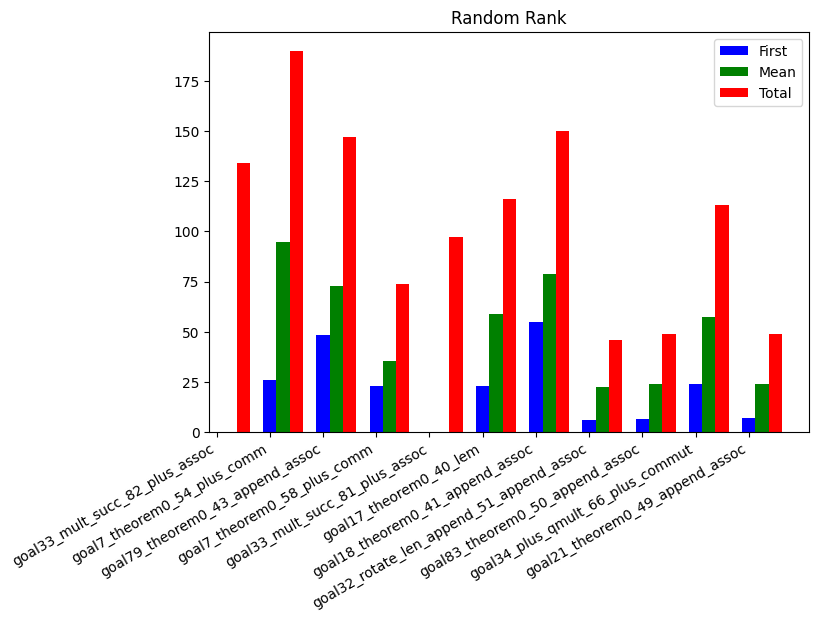

In [13]:
first_ranks, avg_ranks = random_rank(frames)
visualize_ranks("Random Rank", frames, first_ranks, avg_ranks)

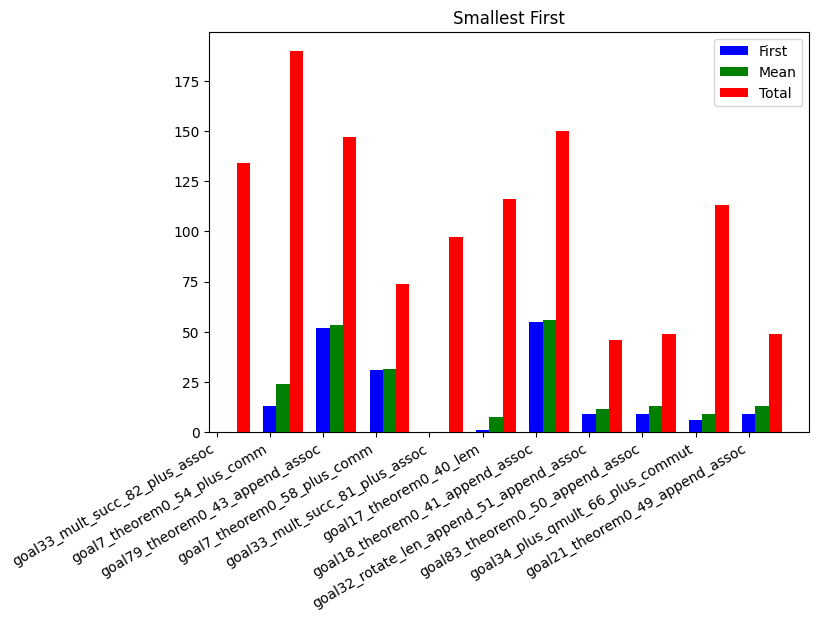

In [14]:
first_ranks, avg_ranks = smallest_first(frames)
visualize_ranks("Smallest First", frames, first_ranks, avg_ranks)

In [14]:
combined_ranks = [(NaN, NaN),
 (112.0, 139.66666666666666),
 (117.0, 117.5),
 (40.0, 46.5),
 (NaN, NaN),
 (79.0, 80.5),
 (139.0, 139.5),
 (5.0, 18.166666666666668),
 (6.0, 21.666666666666668),
 (67.0, 72.0),
 (1.0, 7.5)]

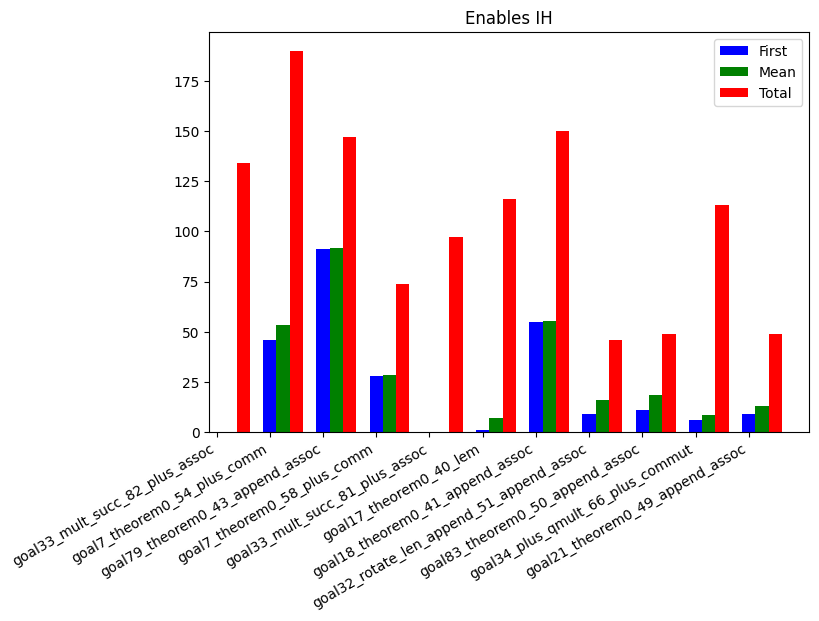

In [17]:
enable_IH_first_rank, enable_IH_avg_rank = enables_IH(frames)
visualize_ranks("Enables IH", frames, enable_IH_first_rank, enable_IH_avg_rank)

In [ ]:
for idx in range(len(frames)):
  print(len(frames[idx][frames[idx]["enables_IH"] == True]), len(frames[idx]))

0 134
155 190
67 147
0 74
0 97
0 116
0 150
20 46
20 49
113 113
0 49


In [ ]:
def cat2_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for i, _ in frames[index].iterrows():
      frames[index].loc[i, "lemma_len"] = len(frames[index].loc[i, "lemma"])
    all_equiv = []
    sorted_frame = frames[index].sort_values(['cat', 'lemma_len'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

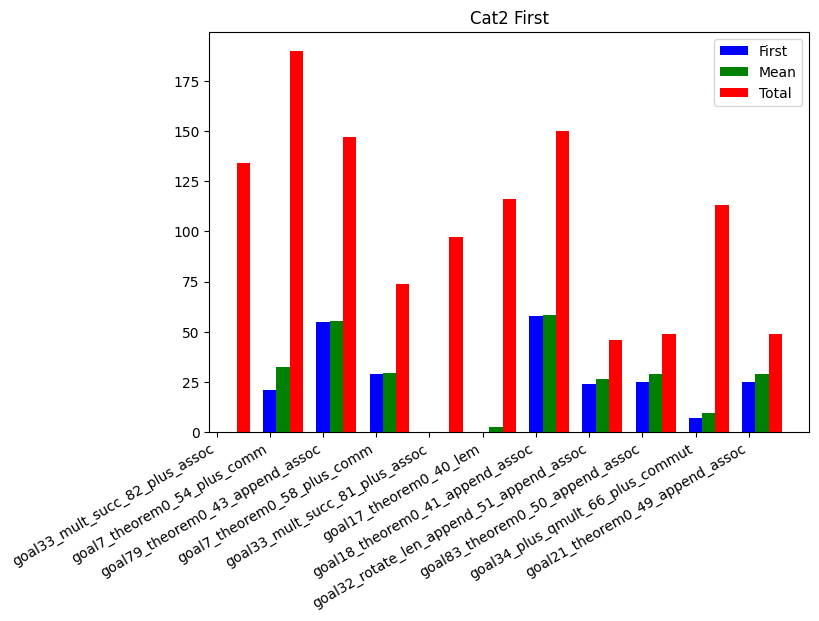

In [ ]:
cat2_first_ranks, cat2_avg_ranks = cat2_first(frames)
visualize_ranks("Cat2 First", frames, cat2_first_ranks, cat2_avg_ranks)